In [44]:
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from pandas import DataFrame

import pandas as pd
from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
from statistics import mean
import statistics
import math
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def dbscan(df, eps, minPoints):
    df_values = df[['value']]
    
    outliersIndexes = []
    clustersAndValues = {}
    clusterIndex = 0
    
    lastValue = df_values.iloc[0].value
    lastIndexSaved = 0
    
    for index, row in df_values.iterrows():
        if index == 0:
            continue
        
        currentValue = row.value
        differenceValue = abs(currentValue - lastValue)
     
        if(differenceValue > eps):
            clusterIndex+=1
      
        if clusterIndex not in clustersAndValues:
            clustersAndValues.setdefault(clusterIndex, [])
            clustersAndValues[clusterIndex].append(currentValue)
        else:
            clustersAndValues[clusterIndex].append(currentValue)
        
        if len(clustersAndValues.get(clusterIndex, 0)) <= minPoints:
            outliersIndexes.append(index)
            lastIndexSaved = index
        
        if len(clustersAndValues.get(clusterIndex, 0)) > minPoints and lastIndexSaved in outliersIndexes:
            outliersIndexes.remove(lastIndexSaved)

        lastValue = currentValue

    return clustersAndValues, outliersIndexes

def compute_distances(values):
    distances = []
    
    if len(values) < 1:
        return
    
    lastValue = values[0]
    for index, value in enumerate(values):
        if index == 0:
            continue
        else:
            distance = abs(value - lastValue) 
            distances.append(distance)
            lastValue = value
            
    return distances

# def compute_distances(values):
#     distances = []
    
#     for index, value in enumerate(values):
#         if(index < len(values) - 1):
#             distance = abs(value - values[index+1]) 
#             distances.append(distance)

#     return distances

def compute_dispersion(values, mean):
    sum = 0
    for value in values:
        subtractionResult = value - mean
        squareResult = subtractionResult ** 2
        sum += squareResult
    totalNumbers = 1 if len(values) == 0 else len(values)    
    divideResult = sum / totalNumbers
    return math.sqrt(divideResult)

def split_anomalies_and_non_anomalies(df):
    anomalies = []
    nonAnomalies = []
    
    for index, row in df.iterrows():
        checkForAnomalyResult = check_for_anomaly(index, df)
        if(0 == checkForAnomalyResult):
            nonAnomalies.append(row['value'])
        elif(1 == checkForAnomalyResult):
            anomalies.append(row['value'])              
        else:
            continue
  
    return anomalies, nonAnomalies

def check_for_anomaly(index, df):
    currentRow = df.iloc[index]
    
    if(index >= len(df) - 1):
        if (1 == currentRow['anomaly']):
            return 1
        else: 
            return 0
        
    nextRow = df.iloc[index + 1]
    if(0 == currentRow['anomaly'] and 0 == nextRow['anomaly']):
        return 0
    elif(1 == currentRow['anomaly'] and 1 == nextRow['anomaly']):
        return 2
    else:
        return 1
    
def evaluate_results_for_confusion_matrix(df, outliersPredictedIndexes):
    results = {"truePositive" : 0, "trueNegative" : 0, "falsePositive" : 0, "falseNegative" : 0}
    truePositive = 0
    trueNegative = 0
    falsePositive = 0
    falseNegative = 0
    
    for index, row in df.iterrows():
        anomalyValue = row['anomaly']
        if anomalyValue == 1:
            if index in outliersPredictedIndexes:
                results["truePositive"] += 1
            else:
                results["falsePositive"] += 1
        else:
            if index in outliersPredictedIndexes:
                results["falseNegative"] += 1
            else:
                results["trueNegative"] += 1    

    return results    

def compute_accuracy(results):
    truePositive = results["truePositive"]
    trueNegative = results["trueNegative"]
    falsePositive = results["falsePositive"]
    falseNegative = results["falseNegative"]
    
    return (truePositive + trueNegative) / (truePositive + trueNegative + falsePositive + falseNegative)
    
def compute_true_negative_rate(results):
    trueNegative = results["trueNegative"]
    falsePositive = results["falsePositive"]
    
    return trueNegative / (trueNegative + falsePositive)

def show_diferences(nonAnomalies, anomalies, epsilon):
    fig = plt.figure()
    ax = fig.add_axes([.4,.4, 4, 4])
    index = 0

    sortedNonAnomalies = sorted(nonAnomalies, reverse=True)
    sortedAnomalies = sorted(anomalies)
   
    index = 0
    
    plt.hlines(0,0,2500) 
    plt.scatter(epsilon, 0, label='skitscat', color='green', s=300, marker="o")
    label = "{:.2f}".format(epsilon)
    plt.text(epsilon-20, 0.00005, label)
    
    for number in sortedNonAnomalies:
        if index < 3:
            plt.scatter(number, 0, label='skitscat', color='blue', s=300, marker="o")
            label = "{:.2f}".format(number)
            if index % 2 == 0:
                plt.text(number-20, 0.00005, label)
            else:
                plt.text(number-20, -0.00005, label)
            index +=1
        else:
            break

    for number in sortedAnomalies:
        if index < 6:
            plt.scatter(number, 0, label='skitscat', color='red', s=300, marker="o")
            label = "{:.2f}".format(number)
            if index % 2 == 0:
                plt.text(number-20, 0.00005, label)
            else:
                plt.text(number-20, -0.00005, label)
            index +=1
        else:
            break
    
        
    ax.set_xlabel('index')
    ax.set_ylabel('differences')
    plt.title('DBScan')
    plt.show()

def show_results_graph(clustersAndValues, outliersIndexes, df):
    fig = plt.figure()
    ax = fig.add_axes([.4,.4, 4, 4])
    colors = ['lime', 'purple', 'mediumblue', 
              'gold', 'darkred', 'aqua', 'yellowgreen', 
              'cyan', 'fuchsia', 'darkviolet', 'teal', 
              'lightcoral', 'skyblue', 'royalblue', 'olive']
    index = 0

    dfAnomalyIndexes = df[df['anomaly'] == 1].index
    for clusterIndex, clusterValues in clustersAndValues.items():
        for value in clusterValues:
            if index in outliersIndexes and index in dfAnomalyIndexes:
                plt.scatter(index, value, label='skitscat', color='red', s=600, marker="X")
                label = (index, " - ", value)
                plt.annotate(label, (index, value))
            elif index in outliersIndexes or index in dfAnomalyIndexes:
                plt.scatter(index, value, label='skitscat', color='black', s=900, marker="h")
                label = (index, " - ", value)
                plt.annotate(label, (index, value))
            else:
                color = colors[(clusterIndex + 1) % len(colors)]
                plt.scatter(index, value, label='skitscat', color=color, s=100, marker="o")

            index +=1
        
    ax.set_xlabel('index')
    ax.set_ylabel('values')
    plt.title('DBScan')
    plt.show()

def show_confusion_matrix(results):
    headerColor = 'skyblue'
    rowOddColor = 'lightcyan'
    rowEvenColor = 'lightblue'
    
    fig = go.Figure(data=[go.Table(
      header=dict(
        values=['<b>Total population</b>','<b>Condition positive</b>','<b>Condition negative</b>'],
        line_color='darkslategray',
        fill_color=headerColor,
        align=['left','center'],
        font=dict(color='white', size=12)
      ),
      cells=dict(
        values=[
          ['Predicted condition positive', 'Predicted condition negative'],
          [results["truePositive"], results["falsePositive"]],
          [results["falseNegative"], results["trueNegative"]]],
        line_color='darkslategray',
        fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
        align = ['left', 'center'],
        font = dict(color = 'darkslategray', size = 11)
        ))
    ])
    
    fig.show()

def show_accuracy_and_true_negative_rate(accuracy, trueNegativeRate):
    headerColor = 'skyblue'
    rowOddColor = 'lightcyan'
    rowEvenColor = 'lightblue'
    
    fig = go.Figure(data=[go.Table(
      header=dict(
        values=['<b>Accuracy</b>','<b>True negative rate</b>'],
        line_color='darkslategray',
        fill_color=headerColor,
        align=['left','center'],
        font=dict(color='white', size=12)
      ),
      cells=dict(
        values=[[accuracy], [trueNegativeRate]],
        line_color='darkslategray',
        fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
        align = ['left', 'center'],
        font = dict(color = 'darkslategray', size = 11)
        ))
    ])
    
    fig.show()

# def show_dataset_histogram(df):    
#     df_values = df[['value']]
    
#     fig = plt.figure()
#     ax = fig.add_axes([.4,.4, 4, 4])
       
#     for index, row in df_values.iterrows():
#         plt.scatter(index, row.value, label='skitscat', color='blue', s=300, marker="x")

#     ax.set_xlabel('index')
#     ax.set_ylabel('differences')
#     plt.title('DBScan')
#     plt.show()
    
#     plt.show()
    
def show_dataset_histogram(df):       
    fig = plt.figure()
    ax = fig.add_axes([.4,.4, 4, 4])
       
    for index, row in df.iterrows():
        plt.bar(index, row.value, width = 0.5, color=['blue'])

    plt.xlabel('index')
    plt.ylabel('differences')
    plt.title('DBScan')
    plt.show()
    
    plt.show()    
    
    
def search_anomalies(df):
    halfIndex = int((len(df)/2))
    anomalies, nonAnomalies = split_anomalies_and_non_anomalies(df[:halfIndex])

    anomalyDistances = compute_distances(anomalies)
    nonAnomalyDistances = compute_distances(nonAnomalies)
    
# to be fixed    
# this a hack for situations when there are no anomalies present in training dataset
#
#     if type(anomalyDistances) is list:
#         minAnomalyDistances = min(anomalyDistances)
#     else:
#         minAnomalyDistances = 0
#     mean = statistics.median([0, max(nonAnomalyDistances)])

    mean = statistics.median([min(anomalyDistances), max(nonAnomalyDistances)])
    print("epsilon - ", mean)
    
    anomaliesDispersion = compute_dispersion(anomalyDistances, mean)
    nonAnomaliesDispersion = compute_dispersion(nonAnomalyDistances, mean)  

    clustersAndValues, predictedOutliersIndexes = dbscan(df, mean, 1)
    
    print("Founded {", len(clustersAndValues.keys()), "} number clusters")
    print("There are {", len(df[df['anomaly'] == 1]), "} anomaly objects presented in the dataset with indexes ", df[df['anomaly'] == 1].index)
    print("And are founded {", len(predictedOutliersIndexes), "} anomaly objects, with indexes: ", predictedOutliersIndexes)

    results = evaluate_results_for_confusion_matrix(df, predictedOutliersIndexes)
    show_confusion_matrix(results)
    
    accuracy = compute_accuracy(results)
    trueNegativeRate = compute_true_negative_rate(results)
    show_accuracy_and_true_negative_rate(accuracy, trueNegativeRate)

    show_results_graph(clustersAndValues, predictedOutliersIndexes, df) 
#     show_diferences(nonAnomalyDistances, anomalyDistances, mean)
    

In [6]:
# ==========================    
# ====== read dframes ======
# ==========================   

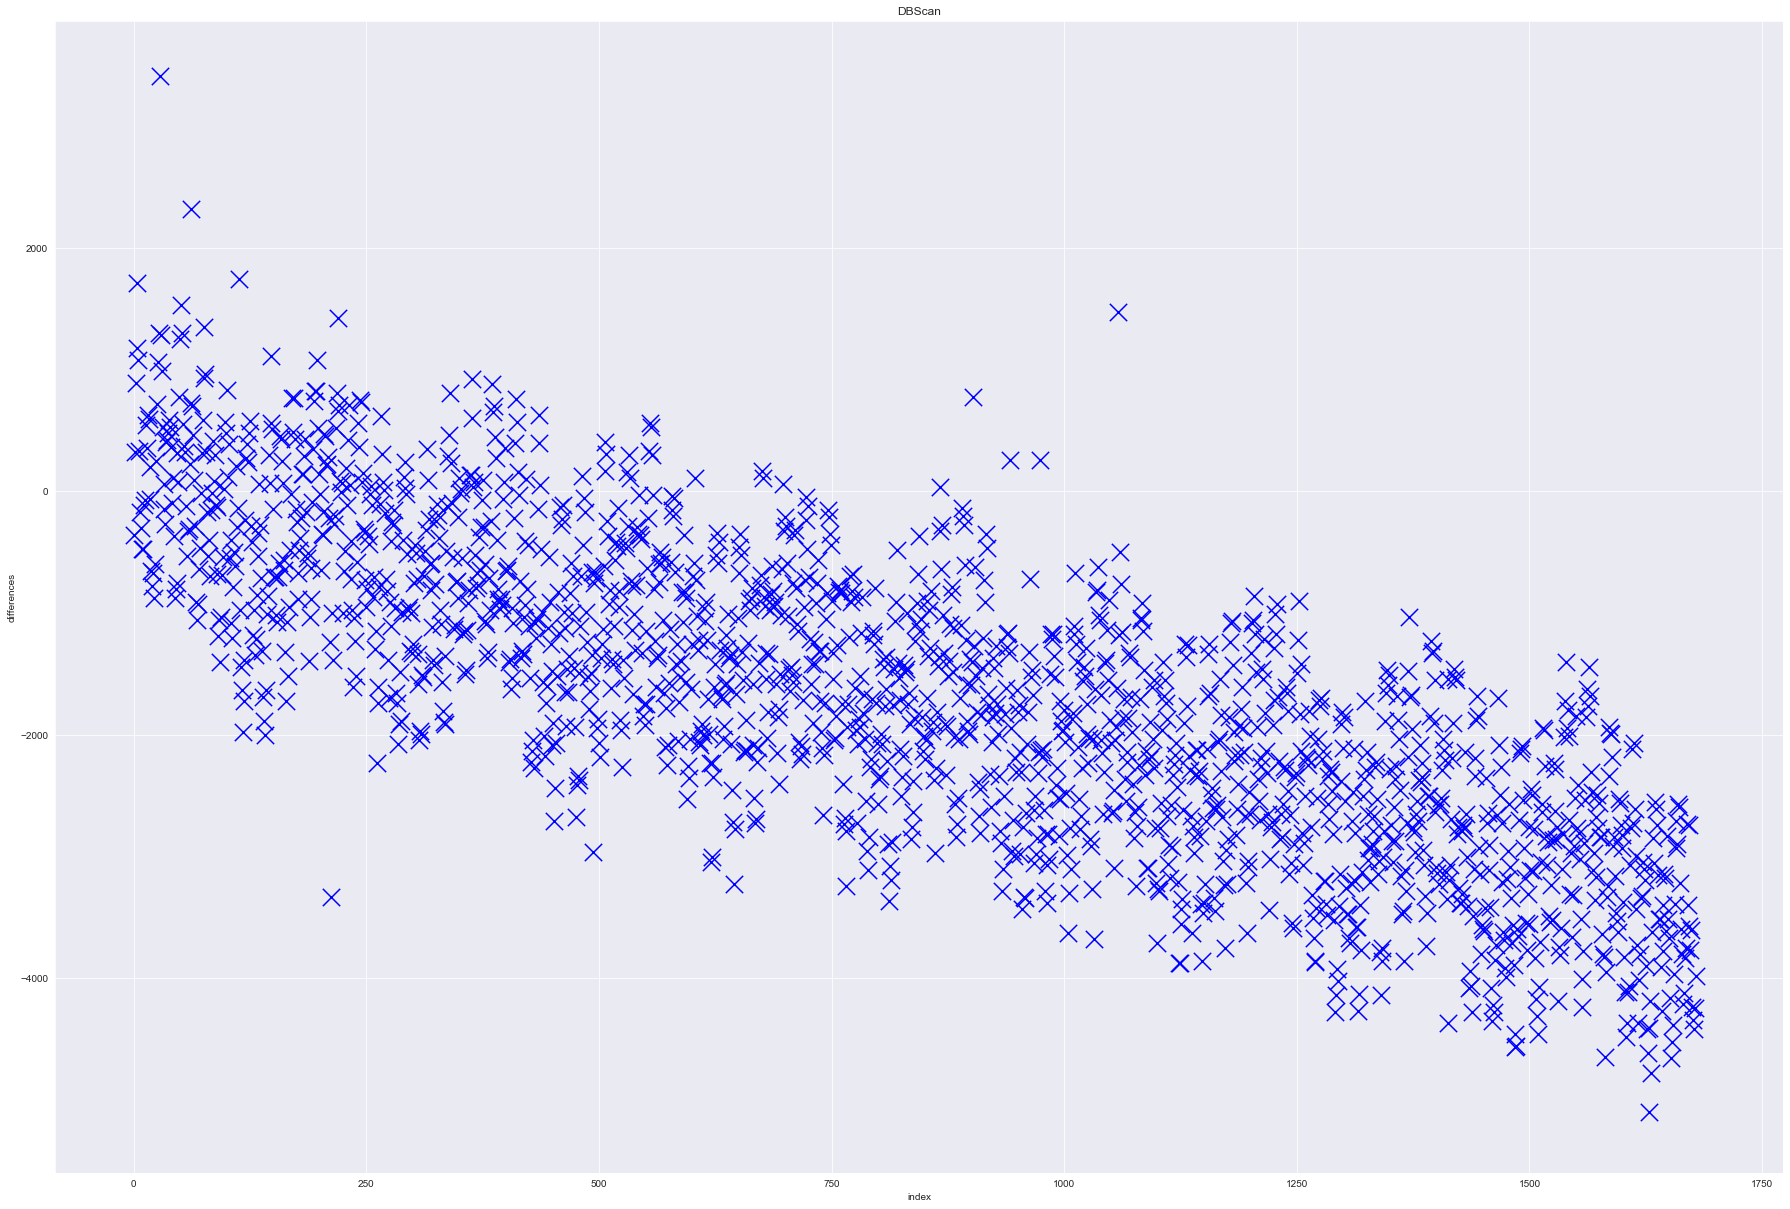

In [33]:
df_TS1 = pd.read_csv("data_sets/A3Benchmark-TS1.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
show_dataset_histogram(df_TS1)
# search_anomalies(df_TS1)
# print(df_TS1[25:35])

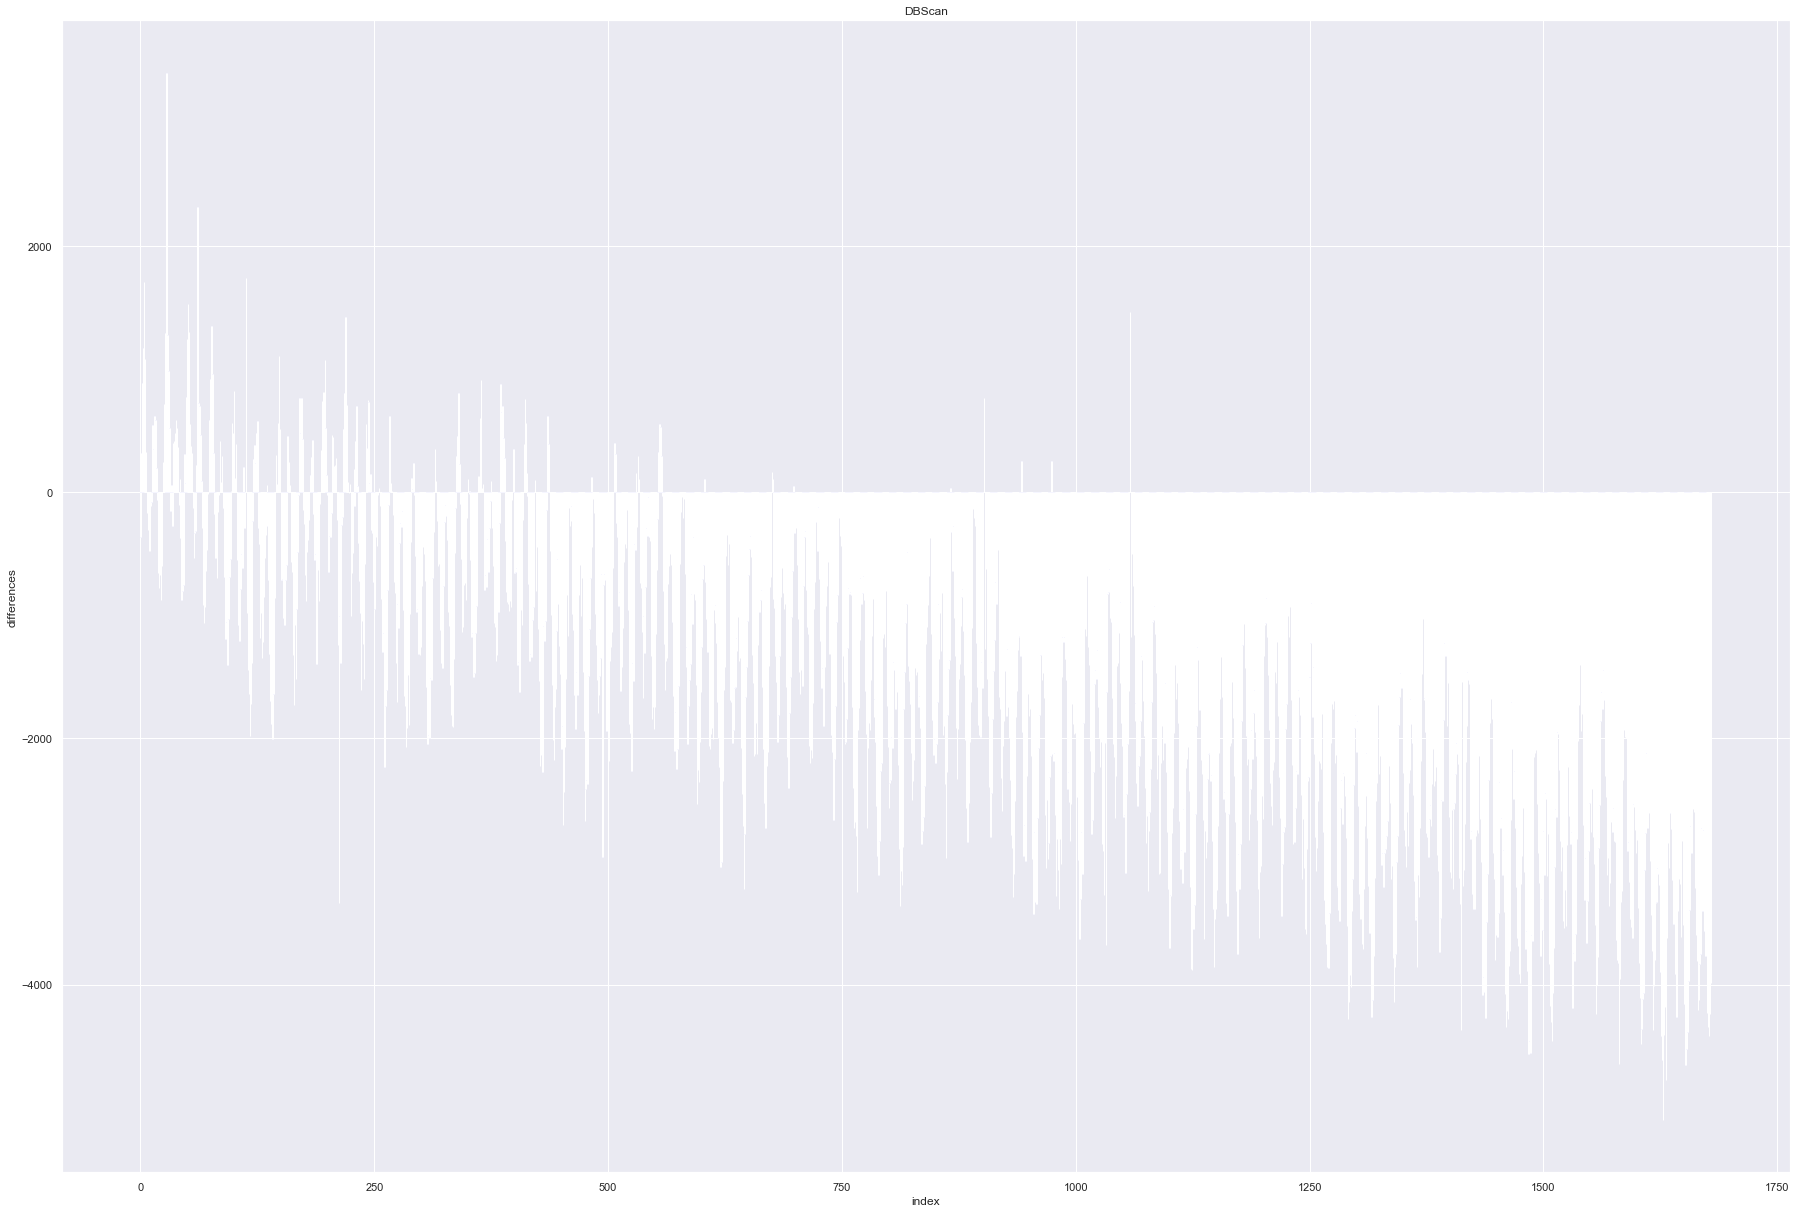

In [45]:
df_TS1 = pd.read_csv("data_sets/A3Benchmark-TS1.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
df_values = df_TS1[['value']]
show_dataset_histogram(df_values)

epsilon -  740.11898967125
Founded { 33 } number clusters
There are { 16 } anomaly objects presented in the dataset with indexes  Int64Index([ 431,  478,  610,  681,  718,  732,  846, 1019, 1080, 1124, 1171,
            1211, 1246, 1411, 1437, 1455],
           dtype='int64')
And are founded { 16 } anomaly objects, with indexes:  [431, 478, 610, 681, 718, 732, 846, 1019, 1080, 1124, 1171, 1211, 1246, 1411, 1437, 1455]


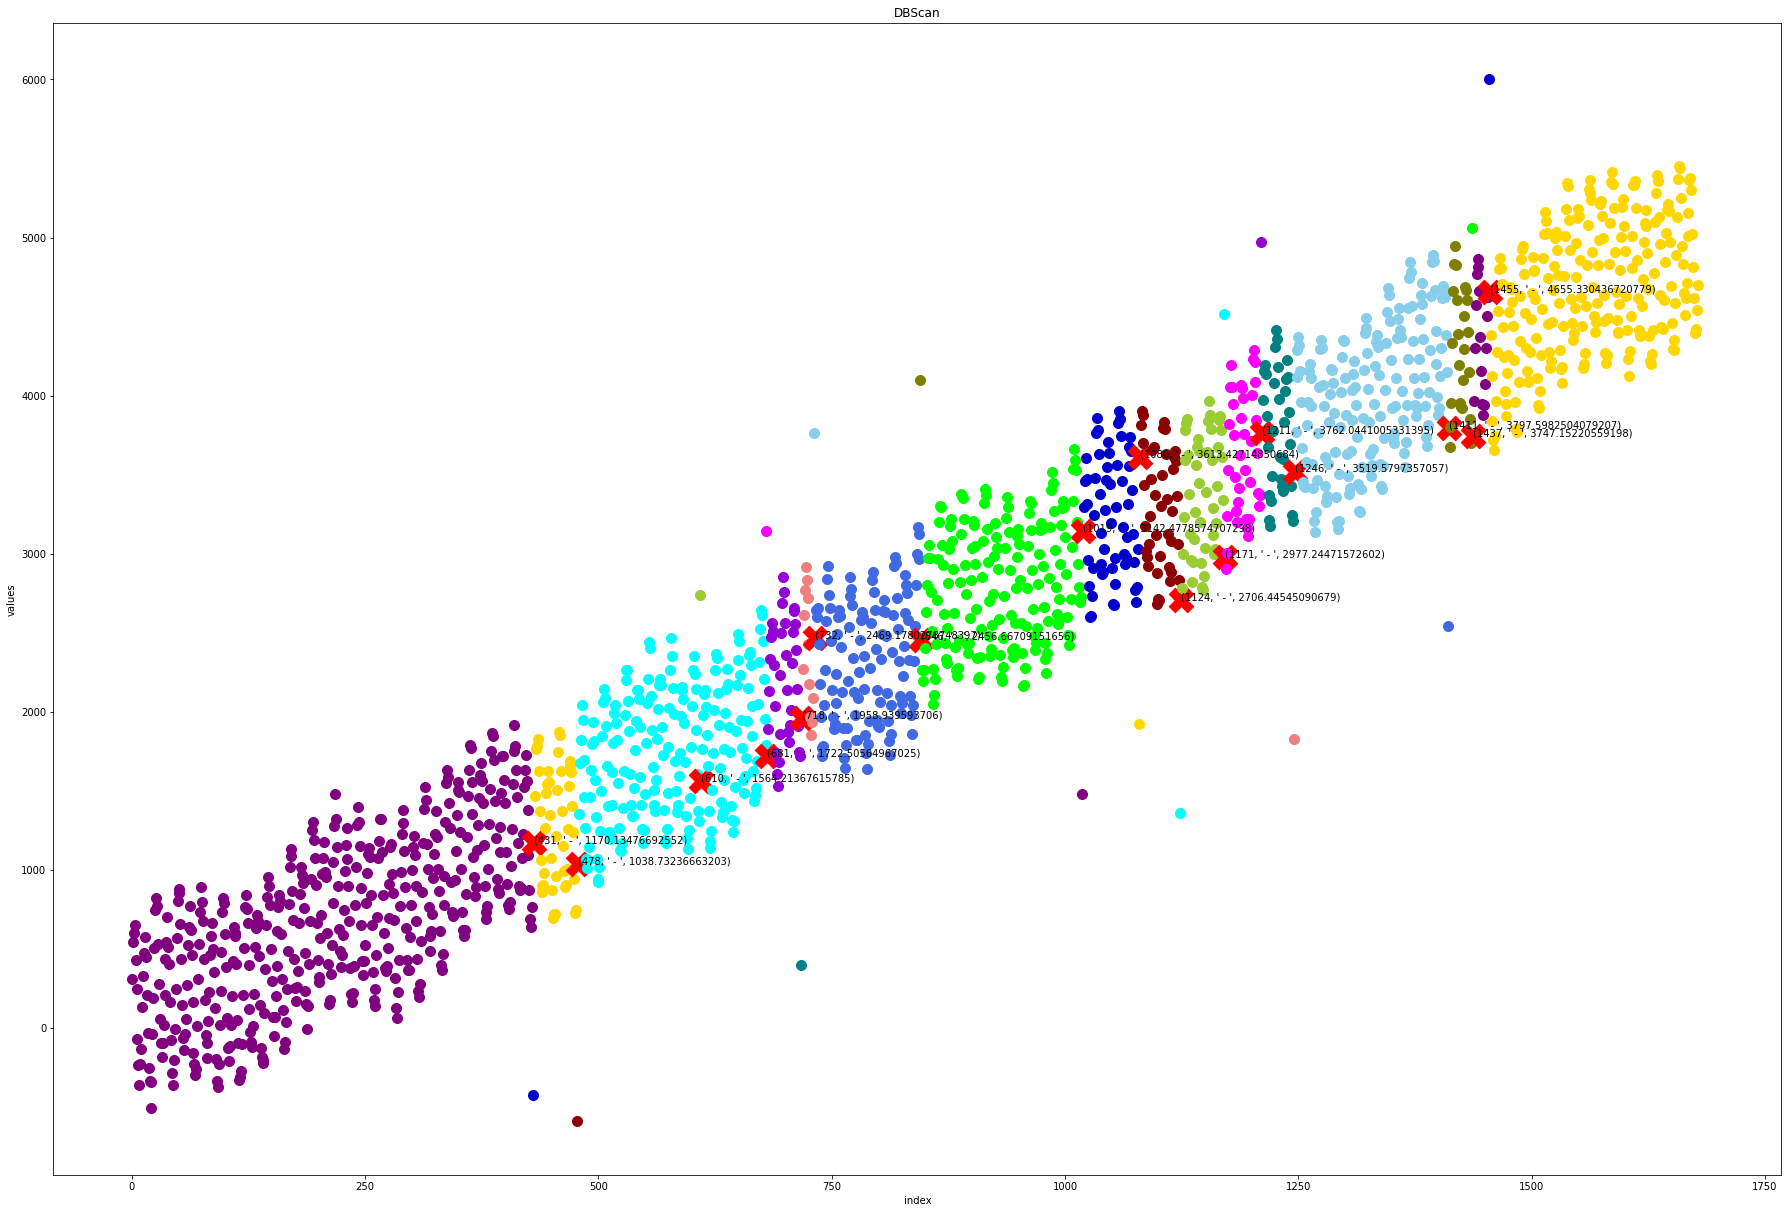

In [16]:
df_TS2 = pd.read_csv("data_sets/A3Benchmark-TS2.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS2)

epsilon -  611.094598676994
Founded { 12 } number clusters
There are { 6 } anomaly objects presented in the dataset with indexes  Int64Index([253, 433, 860, 1316, 1438, 1547], dtype='int64')
And are founded { 5 } anomaly objects, with indexes:  [253, 860, 1316, 1438, 1547]


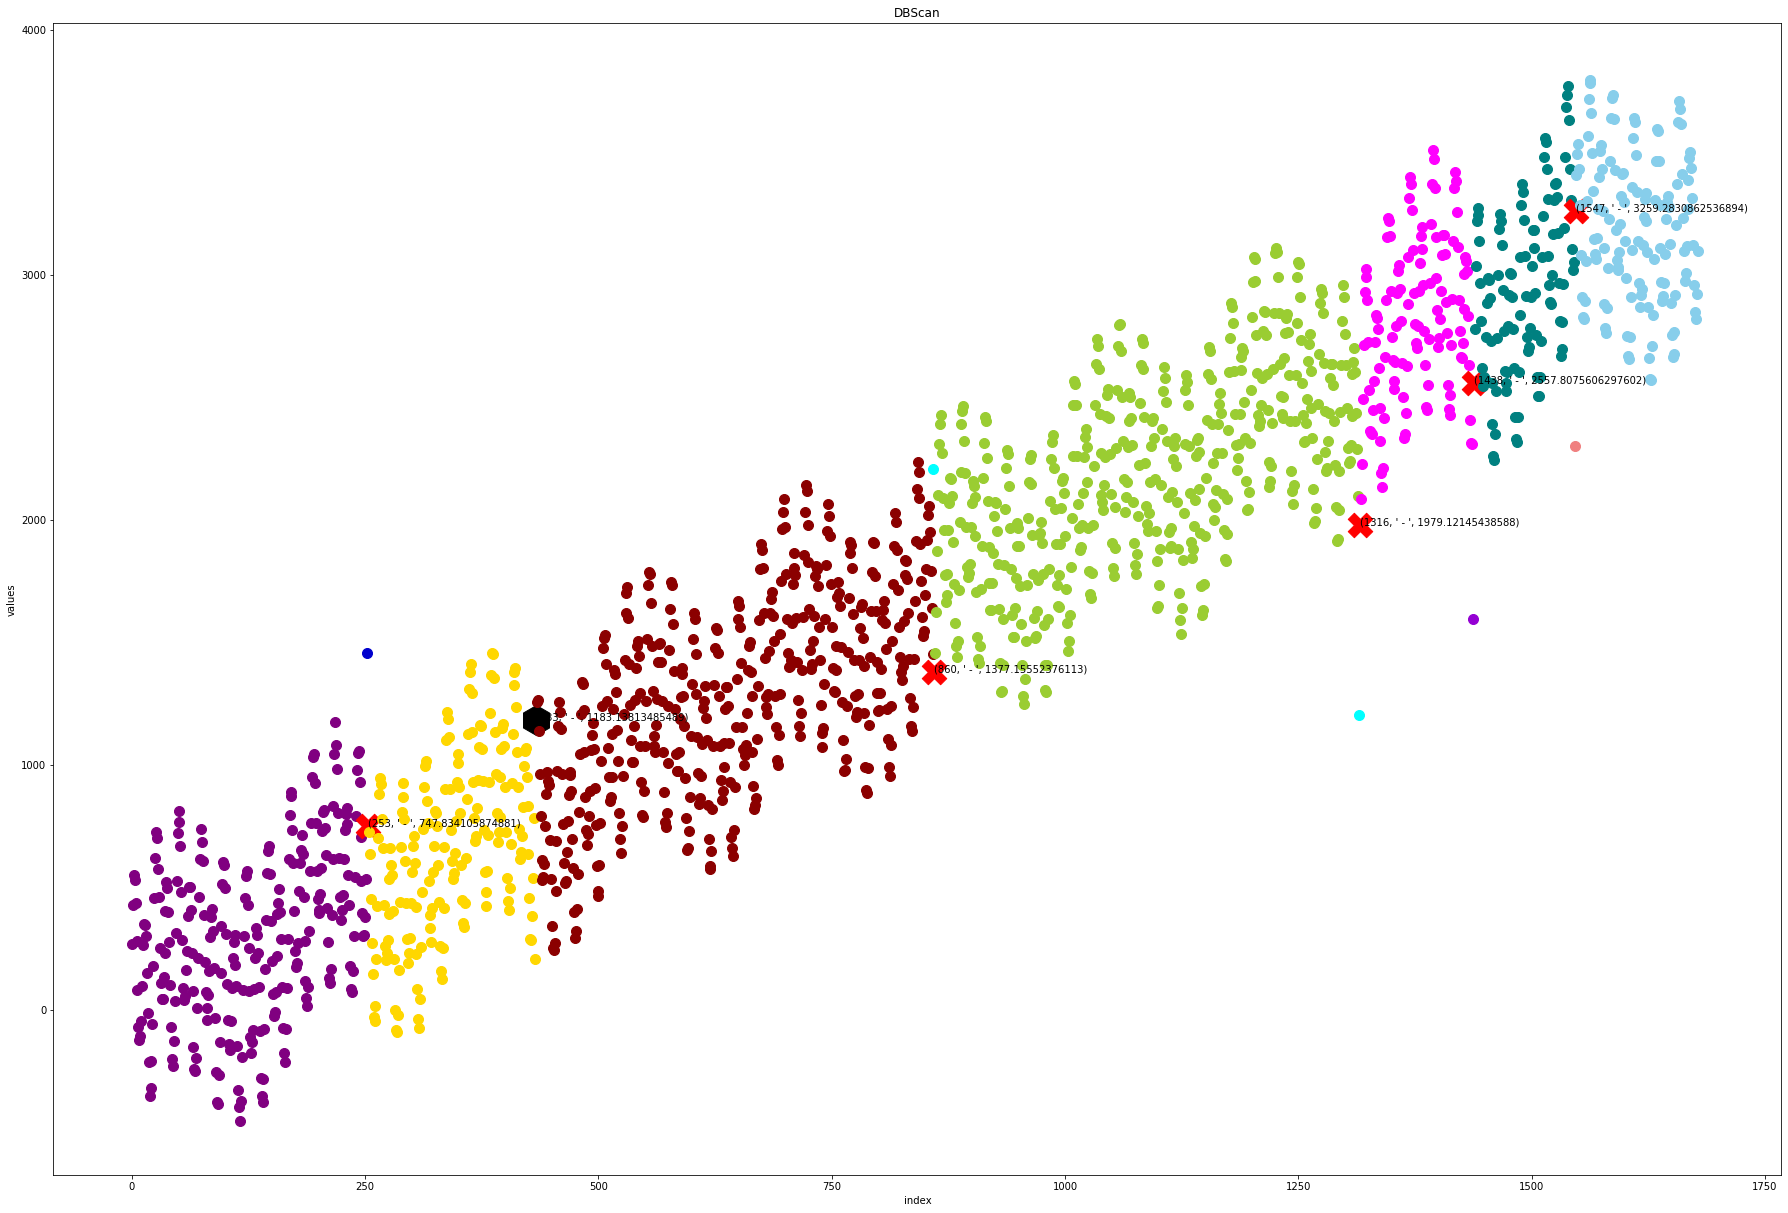

In [17]:
df_TS3 = pd.read_csv("data_sets/A3Benchmark-TS3.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS3)

# print("for 61 diff is ", abs(df_TS3.iloc[433]['value'] - df_TS3.iloc[432]['value']))
# print("for 61 diff is ", abs(df_TS3.iloc[434]['value'] - df_TS3.iloc[433]['value']))


epsilon -  288.07700386700986
Founded { 285 } number clusters
There are { 6 } anomaly objects presented in the dataset with indexes  Int64Index([852, 1196, 1269, 1406, 1501, 1594], dtype='int64')
And are founded { 90 } anomaly objects, with indexes:  [1, 25, 71, 119, 120, 143, 144, 167, 168, 193, 216, 240, 264, 312, 313, 336, 359, 360, 384, 408, 409, 431, 432, 439, 456, 481, 503, 504, 623, 647, 648, 671, 672, 696, 697, 744, 745, 768, 792, 839, 852, 888, 959, 960, 984, 1008, 1009, 1031, 1032, 1033, 1056, 1073, 1079, 1080, 1104, 1127, 1152, 1153, 1176, 1195, 1196, 1199, 1200, 1224, 1248, 1249, 1269, 1270, 1271, 1272, 1273, 1319, 1320, 1321, 1344, 1392, 1406, 1463, 1464, 1487, 1488, 1489, 1501, 1536, 1560, 1561, 1594, 1631, 1632, 1656]


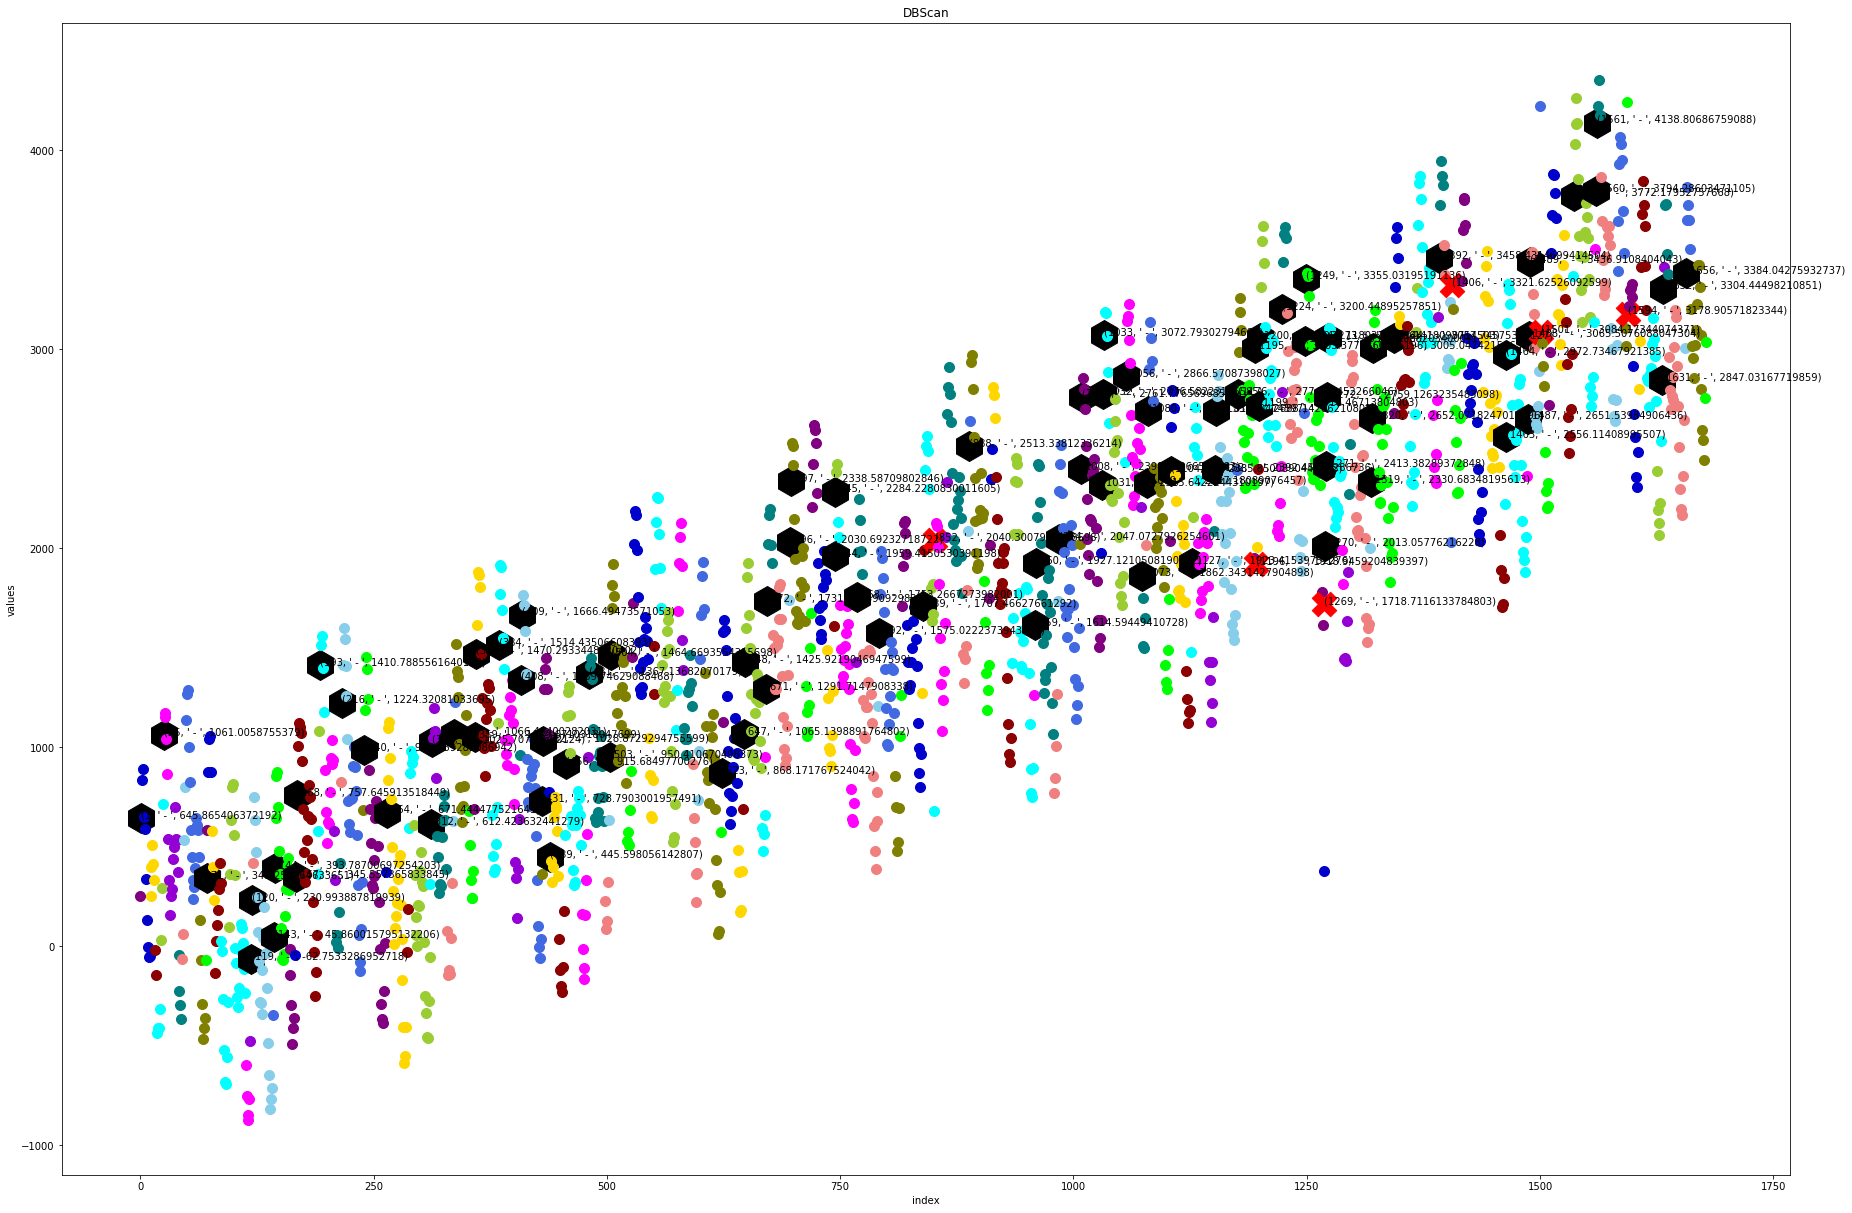

In [19]:
df_TS4 = pd.read_csv("data_sets/A3Benchmark-TS4.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS4)

epsilon -  1094.4519012030275
Founded { 5 } number clusters
There are { 2 } anomaly objects presented in the dataset with indexes  Int64Index([721, 1614], dtype='int64')
And are founded { 2 } anomaly objects, with indexes:  [721, 1614]


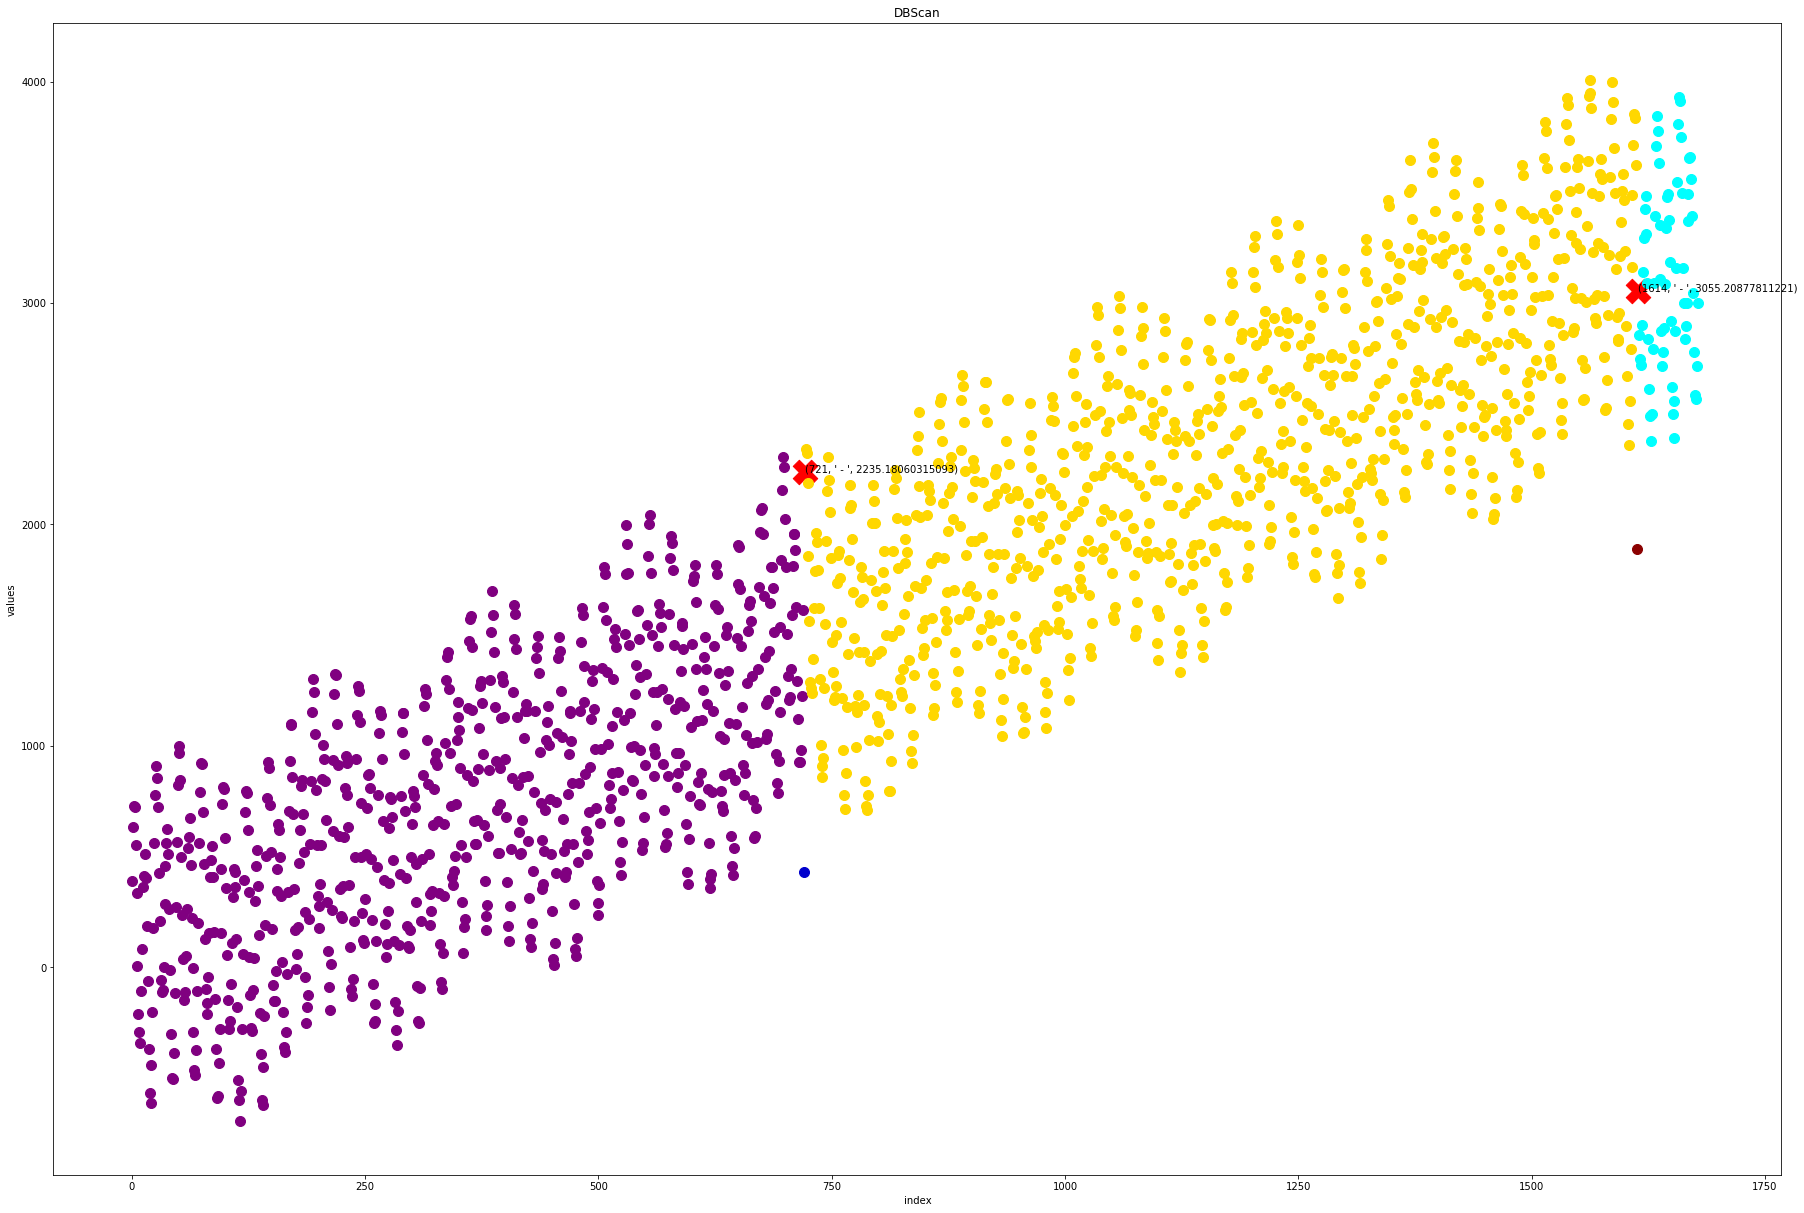

In [21]:
df_TS5 = pd.read_csv("data_sets/A3Benchmark-TS5.csv", sep=r'\s*,\s*', header=0, encoding='ascii', engine='python')
search_anomalies(df_TS5)